# Plotting search results for mock signals

In [1]:
import numpy as np
import json

%matplotlib inline
from matplotlib import pyplot as plt

from glob import glob
plt.style.use('../paper.mplstyle')

In [2]:
# Set where the results files are kept
search_result_files = glob('search_run_*.json')
plot_ifar_limit = 100

In [3]:
# Define some things for style of the plots
psd_styles = {
    'CUT_optimistic':':',
    'cutoff':':',
    'pessimistic':'--',
    'optimistic':'-',
}
psd_style_markers = {
    'cutoff':'x',
    'CUT_optimistic': 'x',
    'pessimistic':'v',
    'optimistic':'^',
}
search_times_before = [0.5,1,4,7,14]

## Load in the data from all search results

In [4]:
search_results_all = {}
for srf in search_result_files:
    with open(srf) as srfp:
        search_results = json.load(srfp)
        search_results_all[search_results['psd_type']] = search_results


## Make Figure 6 - SNR vs time-before-merger

dict_keys(['pessimistic', 'optimistic', 'cutoff'])


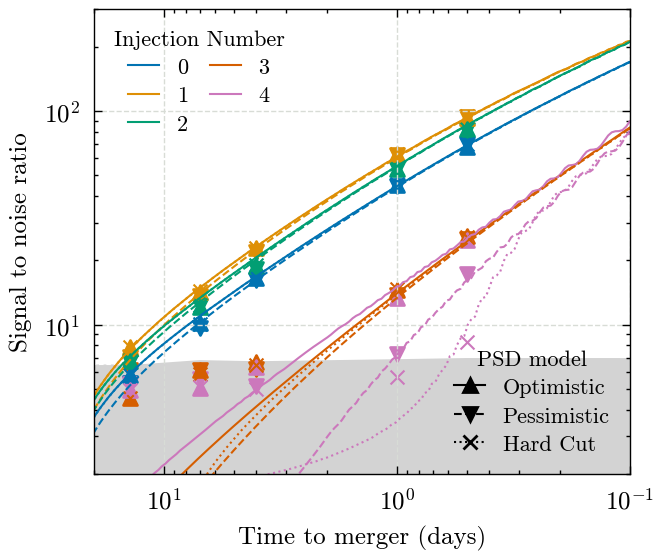

In [7]:
# Make the figure - 1.5 times the normal height so we can see detail
width = plt.rcParams["figure.figsize"][0]
height = plt.rcParams["figure.figsize"][1] * 1.5
inj_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(
    1, figsize=(width, height),
)

for search_results in search_results_all.values():
    for inj_no in range(5):
        ax.scatter(
            search_times_before,
            search_results[str(inj_no)]['snr'],
            marker=psd_style_markers[search_results['psd_type']],
            color=inj_colors[inj_no]
        )
        times = search_results[str(inj_no)]['optimal_snr_all_time']
        snrs = search_results[str(inj_no)]['optimal_snr_all']
        ax.plot(
            times,
            snrs,
            color=inj_colors[inj_no],
            linestyle=psd_styles[search_results['psd_type']]
        )

print(search_results_all.keys())

inj_lines = []
inj_labels = []
for inj_no in range(5):
    inj_lines += [ax.plot([],[], color=inj_colors[inj_no])[0]]
    inj_labels.append(f'{inj_no}')

leg1 = ax.legend(
    inj_lines,
    inj_labels,
    loc='upper left',
    title='Injection Number',
    ncol=2,
)

psd_lines = [
    ax.plot(
        [],
        [],
        linestyle=psd_styles[psd_type],
        marker=psd_style_markers[psd_type],
        color='k'
    )[0]
    for psd_type in ['optimistic', 'pessimistic', 'CUT_optimistic']
]

psd_labels = ['Optimistic', 'Pessimistic', 'Hard Cut']
leg2 = ax.legend(
    psd_lines,
    psd_labels,
    loc='lower right',
    title='PSD model'
)
ax.add_artist(leg1)

# these may not be the same for all psds
# (close but no cigar)
for psd in ['cutoff', 'pessimistic', 'optimistic']:
    search_results = search_results_all[psd]
    fit_coeffs = search_results['alpha']
    fit_thresh = search_results['fit_threshold']
    rate_above = search_results['rate_above']
    # To convert an IFAR limit to an SNR, we invert the formula for
    # the exponential fit
    snr_lim = [
        t + np.log(plot_ifar_limit * r) / a
        for a, r, t in zip(fit_coeffs, rate_above, fit_thresh)
    ]
    ax.fill_between(
        [0] + search_times_before + [1e3],
        np.zeros(len(search_times_before)+2),
        [snr_lim[0]] + snr_lim + [snr_lim[-1]],
        linestyle=psd_styles[psd],
        color='lightgray',
        zorder=-100
    )
ax.loglog()
ax.grid(zorder=-30)
ax.set_ylim(bottom=2, top=300)
ax.set_xlim([0.1, 20])
ax.set_xlabel('Time to merger (days)')
ax.set_ylabel('Signal to noise ratio')
ax.invert_xaxis()
#plt.savefig("Figure6.pdf")

## Plot Figure 7 - the histogram of SNR values for Gaussian Noise

### Generate the histogram

In [5]:
# Extra imports needed for this plot
from matplotlib.colors import LogNorm
from pycbc.events import trigger_fits as trstats

In [6]:
# Grab important data from the dictionary

times_before = [0.5, 1, 4, 7, 14]
snrs = {
    'optimistic':{t: [] for t in times_before},
    'pessimistic':{t: [] for t in times_before},
    'cutoff':{t: [] for t in times_before},
}

fit_thresholds = {}
alpha = {}
sig_alpha = {}
rate_above = {}
psds = []

for psd, results in search_results_all.items():
    psds.append(psd)
    for t in times_before:
        snrs[psd][t] = results['nonoise'][str(t)]
    fit_thresholds[psd] = results['fit_threshold']
    alpha[psd] = results['alpha']
    sig_alpha[psd] = results['alpha_err']
    rate_above[psd] = results['rate_above']

In [7]:
# Make the parameter space used for the histogram

max_snr = 8
min_snr = 3.5

hist_bins = np.linspace(min_snr, max_snr, 101)

bins_trend = np.linspace(
    min([min(fit_thresholds[psd]) for psd in psds]),
    max_snr + 2,
    101
)

In [8]:
# Generate the histograms for each PSD and time before merger

snr_hists = {psd:{t: [] for t in times_before} for psd in psds}
for psd in psds:
    for t, fit_thresh in zip(times_before, fit_thresholds[psd]):
        # Get the histogram
        hist = np.histogram(
            snrs[psd][t],
            bins=hist_bins
        )[0]
        # Make this a reverse-cumulative histogram, and turn it into a rate,
        # this makes if a rate of louder-ranked triggers at each SNR bin
        snr_hists[psd][t] = hist[::-1].cumsum()[::-1] / (len(snrs[psd][t]) / 24)


In [9]:
line_cmap=plt.get_cmap(None)
norm = LogNorm(vmin=3600 / 86400, vmax=1209600 / 86400) 

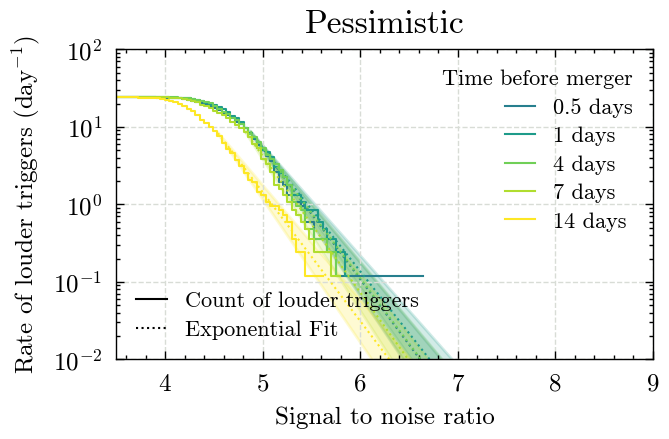

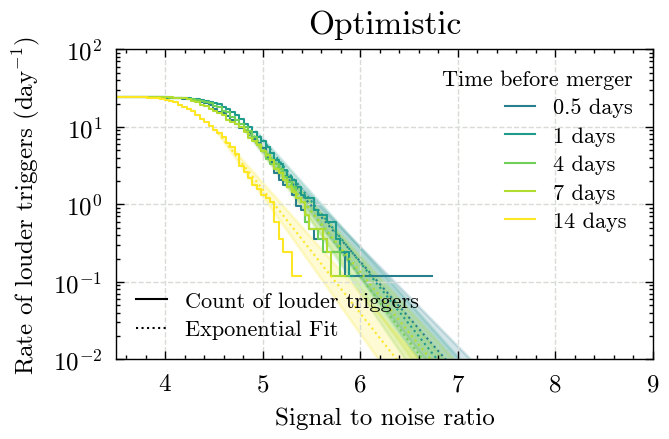

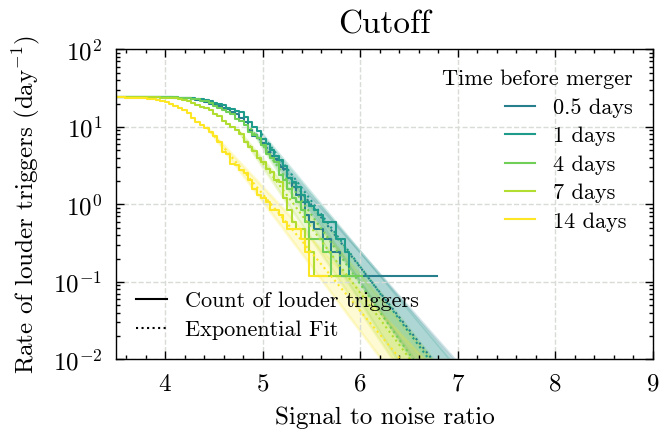

In [16]:
for psd in psds:
    fig, ax = plt.subplots(1)
    col_lines = []
    col_labels = []
    for i, (t, fit_thresh) in enumerate(zip(times_before, fit_thresholds[psd])):
        nz = snr_hists[psd][t] > 0
        # Plot the histogram
        ax.step(
            hist_bins[:-1][nz],
            snr_hists[psd][t][nz],
            color=line_cmap(norm(t)),
            label=f"{t} days before merger"
        )
        # Plot the fit exponential for calculating the FAR
        cum_fit_cent = trstats.cum_fit(
            'exponential',
            bins_trend,
            alpha[psd][i],
            fit_thresh
        ) * rate_above[psd][i]

        trend_nz = cum_fit_cent > 0
        ax.plot(
            bins_trend[trend_nz],
            cum_fit_cent[trend_nz],
            color=line_cmap(norm(t)),
            linestyle=':'
        )

        # Plot errors on this exponential as a shaded region
        cum_fit_plus = trstats.cum_fit(
            'exponential',
            bins_trend,
            alpha[psd][i] + sig_alpha[psd][i],
            fit_thresh
        ) * rate_above[psd][i]

        cum_fit_minus = trstats.cum_fit(
            'exponential',
            bins_trend,
            alpha[psd][i] - sig_alpha[psd][i],
            fit_thresh
        ) * rate_above[psd][i]

        ax.fill_between(
            bins_trend[trend_nz],
            cum_fit_plus[trend_nz],
            cum_fit_minus[trend_nz],
            color=line_cmap(norm(t)),
            alpha=0.2,
            zorder=-100,
        )
        col_lines.append(ax.plot([],[], color=line_cmap(norm(t)))[0])
        col_labels.append(f'{t} days')
    ax.grid()
    ax.semilogy()
    ax.set_xlabel('Signal to noise ratio')
    ax.set_ylabel('Rate of louder triggers (day$^{-1}$)')
    ax.set_ylim(bottom=1e-2, top=1e2)
    ax.set_xlim(3.5, 9)
    leg1 = ax.legend(
        col_lines,
        col_labels,
        loc='upper right',
        title="Time before merger",
    )
    leg1._legend_box.align = "right"
    line_lines = [
        ax.plot([],[],color='k')[0],
        ax.plot([],[],color='k', linestyle=':')[0]
    ]
    line_labels = ['Count of louder triggers', 'Exponential Fit']
    leg2 = ax.legend(line_lines, line_labels, loc='lower left')
    ax.add_artist(leg1)
    #if psd == 'pessimistic':
    #    plt.savefig('Figure7.pdf')
    ax.set_title(psd.title())